In [1]:
import pandas as pd
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import LSTM, Dense
#from tensorflow.keras.callbacks import EarlyStopping
import warnings
from sklearn.metrics import silhouette_score
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
warnings.filterwarnings('ignore')

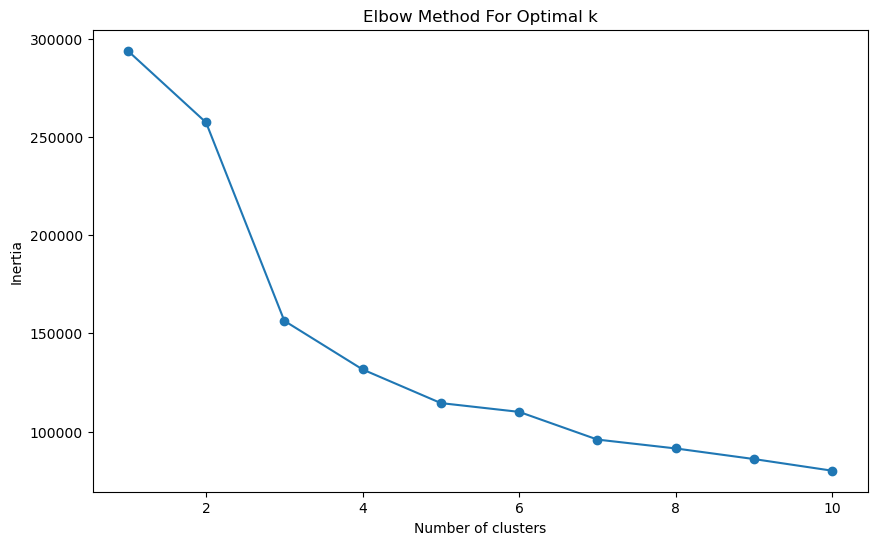

Silhouette Score: 0.248


In [3]:
df = pd.read_excel("preprocessed_data.xlsx")
eval_df = pd.read_excel("evaluation_data_preprocessed.xlsx")


data_for_cluster = df[['Gender', 'Weight_kg', 'Height_cm','Preferred_Clothing_Type', 'Clothing_Size',
                       'Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 
                       'Best_Color_Confidence_g','Best_Color_Confidence_b', 'birthplace_lat','birthplace_lon', 
                       'resi_lat', 'resi_lon', 'Age']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_for_cluster)

# Determine the optimal number of clusters using the Elbow Method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

# Choose the optimal number of clusters (let's assume it's 3 from the plot)
k_optimal = 3
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
kmeans.fit(X_scaled)

clusters = kmeans.predict(X_scaled)

# Add the cluster labels to your original dataframe
data_for_cluster['Cluster'] = clusters
df['Cluster'] = clusters

# Optional: Visualize the clusters if the dimensionality allows
if data_for_cluster.shape[1] <= 5:  # Simplistic check for visualization feasibility
    plt.figure(figsize=(8, 6))
    plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='viridis', marker='o', edgecolor='black', s=50, alpha=0.7)
    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='red', s=250, marker='*', edgecolor='black')
    plt.title('Visualization of clustered data')
    plt.xlabel('Feature 1 (scaled)')
    plt.ylabel('Feature 2 (scaled)')
    plt.show()

score = silhouette_score(X_scaled, clusters)
print('Silhouette Score: %.3f' % score)

# Apply SMOTE
sm = SMOTE(random_state=123)
X, y = df.drop('Preferred_Clothing', axis=1), df['Preferred_Clothing']
X_res, y_res = sm.fit_resample(X, y)

# Combine resampled data back into a DataFrame
df_resampled = pd.DataFrame(X_res, columns=X.columns)
df_resampled['Preferred_Clothing'] = y_res

df_resampled.drop_duplicates(inplace=True)
df_resampled.fillna(0, inplace=True)
                      
X = df_resampled.drop(columns=["Preferred_Clothing"])
y = df_resampled["Preferred_Clothing"]

# Perform stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)



In [4]:
df_preferred_clothing_train = train_df[['Gender', 'Weight_kg', 'Height_cm','Preferred_Clothing_Type', 'Clothing_Size',
                       'Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 
                       'Best_Color_Confidence_g','Best_Color_Confidence_b', 'birthplace_lat','birthplace_lon', 
                       'resi_lat', 'resi_lon', 'Age', 'Preferred_Clothing', 'Cluster']]
df_preferred_clothing_train.drop_duplicates(inplace=True)
df_preferred_clothing_test = test_df[['Gender', 'Weight_kg', 'Height_cm','Preferred_Clothing_Type', 'Clothing_Size',
                       'Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 
                       'Best_Color_Confidence_g','Best_Color_Confidence_b', 'birthplace_lat','birthplace_lon', 
                       'resi_lat', 'resi_lon', 'Age', 'Preferred_Clothing', 'Cluster']]
X_train_1 = df_preferred_clothing_train[['Gender', 'Weight_kg', 'Height_cm','Preferred_Clothing_Type', 'Clothing_Size',
                       'Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 
                       'Best_Color_Confidence_g','Best_Color_Confidence_b', 'birthplace_lat','birthplace_lon', 
                       'resi_lat', 'resi_lon', 'Age', 'Cluster']]
X_test_1 = df_preferred_clothing_test[['Gender', 'Weight_kg', 'Height_cm','Preferred_Clothing_Type', 'Clothing_Size',
                       'Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 
                       'Best_Color_Confidence_g','Best_Color_Confidence_b', 'birthplace_lat','birthplace_lon', 
                       'resi_lat', 'resi_lon', 'Age', 'Cluster']]

y_train_1 = df_preferred_clothing_train["Preferred_Clothing"]
y_test_1 = df_preferred_clothing_test["Preferred_Clothing"]

# Initialize and train RandomForest
rf_model = RandomForestClassifier(criterion= 'gini', max_depth= None, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 250 , random_state=42)
rf_model.fit(X_train_1, y_train_1)

# Initialize and train LightGBM
lgb_model = lgb.LGBMClassifier(boosting_type='dart', learning_rate=0.8, max_depth=12, n_estimators=200, num_leaves=158, subsample=0.4)
lgb_model.fit(X_train_1, y_train_1)

# Predict probabilities for the test set
rf_probs = rf_model.predict_proba(X_test_1)[:, 1]  # Assuming binary classification
lgb_probs = lgb_model.predict_proba(X_test_1)[:, 1]

# Blend the predictions by averaging
blended_probs = (rf_probs + lgb_probs) / 2

# Convert probabilities to final predictions based on a threshold
final_predictions_test = (blended_probs > 0.50).astype(int)

# Evaluate the blended model
accuracy = accuracy_score(y_test, final_predictions_test)
precision = precision_score(y_test, final_predictions_test, average='binary')  # Adjust average as needed
recall = recall_score(y_test, final_predictions_test, average='binary')        # Adjust average as needed
f1 = f1_score(y_test, final_predictions_test, average='binary') 

print("Blended Model Accuracy: %.4f%%" % (accuracy * 100.0))
print("Precision: %.4f" % (precision * 100.0))
print("Recall: %.4f" % (recall * 100.0))
print("F1 Score: %.4f" % (f1 * 100))

# Calculate confusion matrix
cm = confusion_matrix(y_test_1, final_predictions_test)
print("Confusion Matrix:")
print(cm)

# Extracting TP, TN, FP, FN
tn, fp, fn, tp = cm.ravel()
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")



Blended Model Accuracy: 99.5150%
Precision: 99.4206
Recall: 99.7674
F1 Score: 99.5937
Confusion Matrix:
[[2313   20]
 [   8 3432]]
True Positives (TP): 3432
False Positives (FP): 20
True Negatives (TN): 2313
False Negatives (FN): 8


In [5]:
#eval_df = pd.read_excel("eval_output.xlsx")
data_for_cluster_eval = eval_df[['Gender', 'Weight_kg', 'Height_cm','Preferred_Clothing_Type', 'Clothing_Size',
                       'Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 
                       'Best_Color_Confidence_g','Best_Color_Confidence_b', 'birthplace_lat','birthplace_lon', 
                       'resi_lat', 'resi_lon', 'Age']]

X_eval_scaled = scaler.transform(data_for_cluster_eval)
eval_df['Cluster'] = kmeans.predict(X_eval_scaled)


X_eval = eval_df[['Gender', 'Weight_kg', 'Height_cm','Preferred_Clothing_Type', 'Clothing_Size',
                       'Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 
                       'Best_Color_Confidence_g','Best_Color_Confidence_b', 'birthplace_lat','birthplace_lon', 
                       'resi_lat', 'resi_lon', 'Age', 'Cluster']]
y_eval = eval_df[['Preferred_Clothing']]

# Predict probabilities for the test set
rf_probs = rf_model.predict_proba(X_eval)[:, 1]  # Assuming binary classification
lgb_probs = lgb_model.predict_proba(X_eval)[:, 1]

# Blend the predictions by averaging
blended_probs = (rf_probs + lgb_probs) / 2

# Convert probabilities to final predictions based on a threshold
final_predictions_eval = (blended_probs > 0.50).astype(int)

# Evaluate the blended model
accuracy = accuracy_score(y_eval, final_predictions_eval)
precision = precision_score(y_eval, final_predictions_eval, average='binary')  # Adjust average as needed
recall = recall_score(y_eval, final_predictions_eval, average='binary')        # Adjust average as needed
f1 = f1_score(y_eval, final_predictions_eval, average='binary')                # Adjust average as needed

print("Blended Model Accuracy: %.4f%%" % (accuracy * 100.0))
print("Precision: %.4f" % (precision * 100.0))
print("Recall: %.4f" % (recall * 100.0))
print("F1 Score: %.4f" % (f1 * 100))

# Calculate confusion matrix
cm = confusion_matrix(y_eval, final_predictions_eval)
print("Confusion Matrix:")
print(cm)

# Extracting TP, TN, FP, FN
tn, fp, fn, tp = cm.ravel()
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")

Blended Model Accuracy: 85.8178%
Precision: 93.6842
Recall: 90.6109
F1 Score: 92.1219
Confusion Matrix:
[[ 28  54]
 [ 83 801]]
True Positives (TP): 801
False Positives (FP): 54
True Negatives (TN): 28
False Negatives (FN): 83


In [6]:
# Convert y_pred to a DataFrame or Series
y_pred_series = pd.Series(final_predictions_test, name='pred_Preferred_Clothing')

# Ensure the indices match if they are not reset
test_df = test_df.reset_index(drop=True)
y_pred_series = y_pred_series.reset_index(drop=True)

# Combine the predictions with the test DataFrame
df_with_predictions = pd.concat([test_df, y_pred_series], axis=1) 

df_with_piecewear_test = df_with_predictions[df_with_predictions["Preferred_Clothing"] == df_with_predictions["pred_Preferred_Clothing"]]


# Convert y_pred to a DataFrame or Series
y_pred_series = pd.Series(final_predictions_eval, name='pred_Preferred_Clothing')

# Ensure the indices match if they are not reset
eval_df = eval_df.reset_index(drop=True)
y_pred_series = y_pred_series.reset_index(drop=True)

# Combine the predictions with the test DataFrame
eval_df_with_predictions = pd.concat([eval_df, y_pred_series], axis=1) 

df_with_piecewear_eval = eval_df_with_predictions[eval_df_with_predictions["Preferred_Clothing"] == eval_df_with_predictions["pred_Preferred_Clothing"]]



In [7]:
#2 piece wear
df_twopiece_test = df_with_piecewear_test[df_with_piecewear_test["Preferred_Clothing"] == 1]

X_twopiece_test = df_twopiece_test[['Gender', 'Weight_kg', 'Height_cm','Preferred_Clothing_Type', 'Clothing_Size',
                       'Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 
                       'Best_Color_Confidence_g','Best_Color_Confidence_b', 'birthplace_lat','birthplace_lon', 
                       'resi_lat', 'resi_lon', 'Age']]
y_twopiece_test = df_twopiece_test[['Preferred_Bottoms', 'Bottoms_Material','Bottoms_Length', 'Bottoms_Fitting', 'Preferred_Upperwear',
       'Upperwear_Material', 'Upperwear_Length', 'Upperwear_Neckline','Upperwear_Sleeve_Type', 'Upperwear_Pattern']]

df_twopiece_train = train_df[train_df["Preferred_Clothing"] == 1]
df_twopiece_train = df_twopiece_train[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type', 'Clothing_Size','Favourite_Color_r', 
          'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g','Best_Color_Confidence_b', 
          'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age',
            'Preferred_Bottoms', 'Bottoms_Material','Bottoms_Length', 'Bottoms_Fitting', 'Preferred_Upperwear',
       'Upperwear_Material', 'Upperwear_Length', 'Upperwear_Neckline','Upperwear_Sleeve_Type', 'Upperwear_Pattern']]
df_twopiece_train.drop_duplicates(inplace=True)
X_twopiece_train = df_twopiece_train[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type', 'Clothing_Size','Favourite_Color_r', 
          'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g','Best_Color_Confidence_b', 
          'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age']]
y_twopiece_train = df_twopiece_train[['Preferred_Bottoms', 'Bottoms_Material','Bottoms_Length', 'Bottoms_Fitting', 'Preferred_Upperwear',
       'Upperwear_Material', 'Upperwear_Length', 'Upperwear_Neckline','Upperwear_Sleeve_Type', 'Upperwear_Pattern']]

# Initialize a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, criterion='entropy', random_state=42)
#criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
# Wrap it in the MultiOutputClassifier
multi_rf_classifier = MultiOutputClassifier(rf_classifier)

# Training the classifier
multi_rf_classifier.fit(X_twopiece_train, y_twopiece_train)

# Predicting the test set results
y_pred_test = multi_rf_classifier.predict(X_twopiece_test)

# Lists to store metrics for each label
accuracies = []
macro_precisions = []
macro_recalls = []
macro_f1_scores = []
micro_precisions = []
micro_recalls = []
micro_f1_scores = []

# Iterate over each target column
for i in range(y_twopiece_test.shape[1]):
    accuracies.append(accuracy_score(y_twopiece_test.iloc[:, i], y_pred_test[:, i]))
    macro_precisions.append(precision_score(y_twopiece_test.iloc[:, i], y_pred_test[:, i], average="macro", zero_division=0))
    macro_recalls.append(recall_score(y_twopiece_test.iloc[:, i], y_pred_test[:, i], average="macro", zero_division=0))
    macro_f1_scores.append(f1_score(y_twopiece_test.iloc[:, i], y_pred_test[:, i], average="macro", zero_division=0))
    micro_precisions.append(precision_score(y_twopiece_test.iloc[:, i], y_pred_test[:, i], average="micro", zero_division=0))
    micro_recalls.append(recall_score(y_twopiece_test.iloc[:, i], y_pred_test[:, i], average="micro", zero_division=0))
    micro_f1_scores.append(f1_score(y_twopiece_test.iloc[:, i], y_pred_test[:, i], average="micro", zero_division=0))
    
# Output the calculated metrics for each target
for i, column in enumerate(y_twopiece_test.columns):
    print(f"Metrics for {column}:")
    print(f"  Accuracy: {accuracies[i]:.2f}")
    print(f"  Macro Precision: {macro_precisions[i]:.2f}")
    print(f"  Macro Recall: {macro_recalls[i]:.2f}")
    print(f"  Macro F1 Score: {macro_f1_scores[i]:.2f}")
    print(f"  Micro Precision: {micro_precisions[i]:.2f}")
    print(f"  Micro Recall: {micro_recalls[i]:.2f}")
    print(f"  Micro F1 Score: {micro_f1_scores[i]:.2f}")
    print("\n" + "-"*80 + "\n")

# Calculate overall metrics by averaging
overall_accuracy = sum(accuracies) / len(accuracies)
overall_macro_precision = sum(macro_precisions) / len(macro_precisions)
overall_macro_recall = sum(macro_recalls) / len(macro_recalls)
overall_macro_f1 = sum(macro_f1_scores) / len(macro_f1_scores)
overall_micro_precision = sum(micro_precisions) / len(micro_precisions)
overall_micro_recall = sum(micro_recalls) / len(micro_recalls)
overall_micro_f1 = sum(micro_f1_scores) / len(micro_f1_scores)

print(f"\nOverall Metrics:")
print(f"  Overall Accuracy: {overall_accuracy:.2f}")
print(f"  Overall Macro Precision: {overall_macro_precision:.2f}")
print(f"  Overall Macro Recall: {overall_macro_recall:.2f}")
print(f"  Overall Macro F1 Score: {overall_macro_f1:.2f}")
print(f"  Overall Micro Precision: {overall_micro_precision:.2f}")
print(f"  Overall Micro Recall: {overall_micro_recall:.2f}")
print(f"  Overall Micro F1 Score: {overall_micro_f1:.2f}")


Metrics for Preferred_Bottoms:
  Accuracy: 0.89
  Macro Precision: 0.91
  Macro Recall: 0.90
  Macro F1 Score: 0.90
  Micro Precision: 0.89
  Micro Recall: 0.89
  Micro F1 Score: 0.89

--------------------------------------------------------------------------------

Metrics for Bottoms_Material:
  Accuracy: 0.96
  Macro Precision: 0.93
  Macro Recall: 0.89
  Macro F1 Score: 0.90
  Micro Precision: 0.96
  Micro Recall: 0.96
  Micro F1 Score: 0.96

--------------------------------------------------------------------------------

Metrics for Bottoms_Length:
  Accuracy: 0.99
  Macro Precision: 0.77
  Macro Recall: 0.65
  Macro F1 Score: 0.67
  Micro Precision: 0.99
  Micro Recall: 0.99
  Micro F1 Score: 0.99

--------------------------------------------------------------------------------

Metrics for Bottoms_Fitting:
  Accuracy: 0.99
  Macro Precision: 0.86
  Macro Recall: 0.87
  Macro F1 Score: 0.83
  Micro Precision: 0.99
  Micro Recall: 0.99
  Micro F1 Score: 0.99

--------------------

In [8]:
column_name = ["pred_"+col for col in y_twopiece_test.columns]
y_pred_df = pd.DataFrame(y_pred_test, columns=column_name, index=y_twopiece_test.index)
df_with_predictions = pd.merge(df_with_predictions, y_pred_df, left_index=True, right_index=True, how='left')

In [9]:
#2 piece wear
df_twopiece_eval = df_with_piecewear_eval[df_with_piecewear_eval["Preferred_Clothing"] == 1]

X_twopiece_eval = df_twopiece_eval[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type', 'Clothing_Size','Favourite_Color_r', 
          'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g','Best_Color_Confidence_b', 
          'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age']]
y_twopiece_eval = df_twopiece_eval[['Preferred_Bottoms', 'Bottoms_Material','Bottoms_Length', 'Bottoms_Fitting', 'Preferred_Upperwear',
       'Upperwear_Material', 'Upperwear_Length', 'Upperwear_Neckline','Upperwear_Sleeve_Type', 'Upperwear_Pattern']]



# Predicting the test set results
y_pred_eval = multi_rf_classifier.predict(X_twopiece_eval)

# Initialize lists to store the metrics for each target
accuracies = []
macro_precisions = []
macro_recalls = []
macro_f1_scores = []
micro_precisions = []
micro_recalls = []
micro_f1_scores = []

# Iterate over each target column
for i in range(y_twopiece_eval.shape[1]):
    accuracies.append(accuracy_score(y_twopiece_eval.iloc[:, i], y_pred_eval[:, i]))
    macro_precisions.append(precision_score(y_twopiece_eval.iloc[:, i], y_pred_eval[:, i], average='macro', zero_division=0))
    macro_recalls.append(recall_score(y_twopiece_eval.iloc[:, i], y_pred_eval[:, i], average='macro', zero_division=0))
    macro_f1_scores.append(f1_score(y_twopiece_eval.iloc[:, i], y_pred_eval[:, i], average='macro', zero_division=0))
    micro_precisions.append(precision_score(y_twopiece_eval.iloc[:, i], y_pred_eval[:, i], average='micro', zero_division=0))
    micro_recalls.append(recall_score(y_twopiece_eval.iloc[:, i], y_pred_eval[:, i], average='micro', zero_division=0))
    micro_f1_scores.append(f1_score(y_twopiece_eval.iloc[:, i], y_pred_eval[:, i], average='micro', zero_division=0))

# Output the calculated metrics for each target
for i, column in enumerate(y_twopiece_train.columns):
    print(f"Metrics for {column}:")
    print(f"  Accuracy: {accuracies[i]:.2f}")
    print(f"  Macro Precision: {macro_precisions[i]:.2f}")
    print(f"  Macro Recall: {macro_recalls[i]:.2f}")
    print(f"  Macro F1 Score: {macro_f1_scores[i]:.2f}")
    print(f"  Micro Precision: {micro_precisions[i]:.2f}")
    print(f"  Micro Recall: {micro_recalls[i]:.2f}")
    print(f"  Micro F1 Score: {micro_f1_scores[i]:.2f}")
    print("\n" + "-"*80 + "\n")

# Calculate overall metrics by averaging
average_accuracy = sum(accuracies) / len(accuracies)
average_macro_precision = sum(macro_precisions) / len(macro_precisions)
average_macro_recall = sum(macro_recalls) / len(macro_recalls)
average_macro_f1 = sum(macro_f1_scores) / len(macro_f1_scores)
average_micro_precision = sum(micro_precisions) / len(micro_precisions)
average_micro_recall = sum(micro_recalls) / len(micro_recalls)
average_micro_f1 = sum(micro_f1_scores) / len(micro_f1_scores)

print(f"\nOverall Metrics:")
print(f"  Average Accuracy: {average_accuracy:.2f}")
print(f"  Average Macro Precision: {average_macro_precision:.2f}")
print(f"  Average Macro Recall: {average_macro_recall:.2f}")
print(f"  Average Macro F1 Score: {average_macro_f1:.2f}")
print(f"  Average Micro Precision: {average_micro_precision:.2f}")
print(f"  Average Micro Recall: {average_micro_recall:.2f}")
print(f"  Average Micro F1 Score: {average_micro_f1:.2f}")


Metrics for Preferred_Bottoms:
  Accuracy: 0.45
  Macro Precision: 0.19
  Macro Recall: 0.14
  Macro F1 Score: 0.13
  Micro Precision: 0.45
  Micro Recall: 0.45
  Micro F1 Score: 0.45

--------------------------------------------------------------------------------

Metrics for Bottoms_Material:
  Accuracy: 0.53
  Macro Precision: 0.15
  Macro Recall: 0.17
  Macro F1 Score: 0.16
  Micro Precision: 0.53
  Micro Recall: 0.53
  Micro F1 Score: 0.53

--------------------------------------------------------------------------------

Metrics for Bottoms_Length:
  Accuracy: 0.74
  Macro Precision: 0.15
  Macro Recall: 0.20
  Macro F1 Score: 0.17
  Micro Precision: 0.74
  Micro Recall: 0.74
  Micro F1 Score: 0.74

--------------------------------------------------------------------------------

Metrics for Bottoms_Fitting:
  Accuracy: 0.43
  Macro Precision: 0.49
  Macro Recall: 0.24
  Macro F1 Score: 0.25
  Micro Precision: 0.43
  Micro Recall: 0.43
  Micro F1 Score: 0.43

--------------------

In [10]:
column_name = ["pred_"+col for col in y_twopiece_eval.columns]
y_pred_df = pd.DataFrame(y_pred_eval, columns=column_name, index=y_twopiece_eval.index)
eval_df_with_predictions = pd.merge(eval_df_with_predictions, y_pred_df, left_index=True, right_index=True, how='left')

In [11]:
#2 piece wear
X_color_twopiece_test = df_twopiece_test[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type', 'Clothing_Size','Favourite_Color_r', 
           'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g','Best_Color_Confidence_b', 
           'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age']]
y_color_twopiece_test = df_twopiece_test[['Preferred_Bottoms', 'Bottoms_Color_r', 'Bottoms_Color_g','Bottoms_Color_b', 'Preferred_Upperwear',
       'Upperwear_Color_r', 'Upperwear_Color_g', 'Upperwear_Color_b']]

df_color_twopiece_train = train_df[train_df["Preferred_Clothing"] == 1]
df_color_twopiece_train = df_color_twopiece_train[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type', 'Clothing_Size','Favourite_Color_r', 
           'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g','Best_Color_Confidence_b', 
           'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age', 
            'Preferred_Bottoms', 'Bottoms_Color_r', 'Bottoms_Color_g','Bottoms_Color_b', 'Preferred_Upperwear',
       'Upperwear_Color_r', 'Upperwear_Color_g', 'Upperwear_Color_b']]
df_color_twopiece_train.drop_duplicates(inplace=True)
X_color_twopiece_train = df_color_twopiece_train[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type', 'Clothing_Size','Favourite_Color_r', 
           'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g','Best_Color_Confidence_b', 
           'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age']]
y_color_twopiece_train = df_color_twopiece_train[['Preferred_Bottoms', 'Bottoms_Color_r', 'Bottoms_Color_g','Bottoms_Color_b', 'Preferred_Upperwear',
       'Upperwear_Color_r', 'Upperwear_Color_g', 'Upperwear_Color_b']]

# Normalize features and targets
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X_color_twopiece_train)
y_scaled = scaler_y.fit_transform(y_color_twopiece_train)
X_test_scaled = scaler_X.transform(X_color_twopiece_test)
y_test_scaled = scaler_y.transform(y_color_twopiece_test)

# Split data into train and test sets
#X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Reshape input to be [samples, time steps, features]
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Build LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(1, X_scaled.shape[2])),
    Dense(y_scaled.shape[1])
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
model.fit(X_scaled, y_scaled, epochs=100, batch_size=32, validation_data=(X_test_scaled, y_test_scaled), callbacks=[early_stopping])

# Evaluate the model
test_loss = model.evaluate(X_test_scaled, y_test_scaled)
print(f'Test Loss: {test_loss}')

model.save('lstm_model_2.h5')

NameError: name 'Sequential' is not defined

In [ ]:
X_color_twopiece_eval = df_twopiece_eval[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type', 'Clothing_Size','Favourite_Color_r', 
           'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g','Best_Color_Confidence_b', 
           'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age']]
y_color_twopiece_eval = df_twopiece_eval[['Preferred_Bottoms', 'Bottoms_Color_r', 'Bottoms_Color_g','Bottoms_Color_b', 'Preferred_Upperwear',
       'Upperwear_Color_r', 'Upperwear_Color_g', 'Upperwear_Color_b']]

X_eval_scaled = scaler_X.transform(X_color_twopiece_eval)
y_eval_scaled = scaler_y.transform(y_color_twopiece_eval)

X_eval_scaled = X_eval_scaled.reshape((X_eval_scaled.shape[0], 1, X_eval_scaled.shape[1]))

test_loss = model.evaluate(X_eval_scaled, y_eval_scaled)

print(f'Test Loss: {test_loss}')


In [12]:
#2 piece wear
df_onepiece_test = df_with_piecewear_test[df_with_piecewear_test["Preferred_Clothing"] == 0]

X_onepiece_test = df_onepiece_test[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type', 'Clothing_Size','Favourite_Color_r', 
          'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g','Best_Color_Confidence_b', 
          'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age']]
y_onepiece_test = df_onepiece_test[['Favourite_Single_Piece', 'Single_Piece_Material', 'Single_Piece_Fitting', 'Single_Piece_Length',
          'Single_Piece_Sleeves', 'Single_Piece_Neckline', 'Single_Piece_Pattern']]

df_onepiece_train = train_df[train_df["Preferred_Clothing"] == 0]
df_onepiece_train = df_onepiece_train[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type', 'Clothing_Size','Favourite_Color_r', 
        'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g','Best_Color_Confidence_b', 
        'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age', 'Favourite_Single_Piece', 'Single_Piece_Material', 
        'Single_Piece_Fitting', 'Single_Piece_Length','Single_Piece_Sleeves', 'Single_Piece_Neckline', 'Single_Piece_Pattern']]
df_onepiece_train.drop_duplicates(inplace=True)
X_onepiece_train = df_onepiece_train[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type', 'Clothing_Size','Favourite_Color_r', 
          'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g','Best_Color_Confidence_b', 
          'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age']]
y_onepiece_train = df_onepiece_train[['Favourite_Single_Piece', 'Single_Piece_Material', 'Single_Piece_Fitting', 'Single_Piece_Length',
          'Single_Piece_Sleeves', 'Single_Piece_Neckline', 'Single_Piece_Pattern']]

# Initialize a Random Forest Classifier
rf_classifier = RandomForestClassifier(criterion='entropy', max_depth=None, min_samples_leaf=1, min_samples_split= 2, n_estimators=200, random_state=42)

# Wrap it in the MultiOutputClassifier
multi_rf_classifier = MultiOutputClassifier(rf_classifier)

# Training the classifier
multi_rf_classifier.fit(X_onepiece_train, y_onepiece_train)

# Predicting the test set results
y_pred_test = multi_rf_classifier.predict(X_onepiece_test)

# Initialize lists to store the metrics for each target
accuracies = []
macro_precisions = []
macro_recalls = []
macro_f1_scores = []
micro_precisions = []
micro_recalls = []
micro_f1_scores = []

# Iterate over each target column
for i in range(y_onepiece_test.shape[1]):
    accuracies.append(accuracy_score(y_onepiece_test.iloc[:, i], y_pred_test[:, i]))
    macro_precisions.append(precision_score(y_onepiece_test.iloc[:, i], y_pred_test[:, i], average='macro', zero_division=0))
    macro_recalls.append(recall_score(y_onepiece_test.iloc[:, i], y_pred_test[:, i], average='macro', zero_division=0))
    macro_f1_scores.append(f1_score(y_onepiece_test.iloc[:, i], y_pred_test[:, i], average='macro', zero_division=0))
    micro_precisions.append(precision_score(y_onepiece_test.iloc[:, i], y_pred_test[:, i], average='micro', zero_division=0))
    micro_recalls.append(recall_score(y_onepiece_test.iloc[:, i], y_pred_test[:, i], average='micro', zero_division=0))
    micro_f1_scores.append(f1_score(y_onepiece_test.iloc[:, i], y_pred_test[:, i], average='micro', zero_division=0))

# Output the calculated metrics for each target
for i, column in enumerate(y_onepiece_train.columns):
    print(f"Metrics for {column}:")
    print(f"  Accuracy: {accuracies[i]:.2f}")
    print(f"  Macro Precision: {macro_precisions[i]:.2f}")
    print(f"  Macro Recall: {macro_recalls[i]:.2f}")
    print(f"  Macro F1 Score: {macro_f1_scores[i]:.2f}")
    print(f"  Micro Precision: {micro_precisions[i]:.2f}")
    print(f"  Micro Recall: {micro_recalls[i]:.2f}")
    print(f"  Micro F1 Score: {micro_f1_scores[i]:.2f}")
    print("\n" + "-"*80 + "\n")

# Calculate overall metrics by averaging
overall_accuracy = sum(accuracies) / len(accuracies)
overall_macro_precision = sum(macro_precisions) / len(macro_precisions)
overall_macro_recall = sum(macro_recalls) / len(macro_recalls)
overall_macro_f1 = sum(macro_f1_scores) / len(macro_f1_scores)
overall_micro_precision = sum(micro_precisions) / len(micro_precisions)
overall_micro_recall = sum(micro_recalls) / len(micro_recalls)
overall_micro_f1 = sum(micro_f1_scores) / len(micro_f1_scores)

print(f"\nOverall Metrics:")
print(f"  Overall Accuracy: {overall_accuracy:.2f}")
print(f"  Overall Macro Precision: {overall_macro_precision:.2f}")
print(f"  Overall Macro Recall: {overall_macro_recall:.2f}")
print(f"  Overall Macro F1 Score: {overall_macro_f1:.2f}")
print(f"  Overall Micro Precision: {overall_micro_precision:.2f}")
print(f"  Overall Micro Recall: {overall_micro_recall:.2f}")
print(f"  Overall Micro F1 Score: {overall_micro_f1:.2f}")


Metrics for Favourite_Single_Piece:
  Accuracy: 0.87
  Macro Precision: 0.48
  Macro Recall: 0.48
  Macro F1 Score: 0.46
  Micro Precision: 0.87
  Micro Recall: 0.87
  Micro F1 Score: 0.87

--------------------------------------------------------------------------------

Metrics for Single_Piece_Material:
  Accuracy: 0.92
  Macro Precision: 0.80
  Macro Recall: 0.77
  Macro F1 Score: 0.77
  Micro Precision: 0.92
  Micro Recall: 0.92
  Micro F1 Score: 0.92

--------------------------------------------------------------------------------

Metrics for Single_Piece_Fitting:
  Accuracy: 0.94
  Macro Precision: 0.92
  Macro Recall: 0.90
  Macro F1 Score: 0.91
  Micro Precision: 0.94
  Micro Recall: 0.94
  Micro F1 Score: 0.94

--------------------------------------------------------------------------------

Metrics for Single_Piece_Length:
  Accuracy: 0.89
  Macro Precision: 0.67
  Macro Recall: 0.65
  Macro F1 Score: 0.66
  Micro Precision: 0.89
  Micro Recall: 0.89
  Micro F1 Score: 0.89



In [13]:
column_name = ["pred_"+col for col in y_onepiece_test.columns]
y_pred_df = pd.DataFrame(y_pred_test, columns=column_name, index=y_onepiece_test.index)
df_with_predictions = pd.merge(df_with_predictions, y_pred_df, left_index=True, right_index=True, how='left')

In [14]:
#2 piece wear
df_onepiece_eval = df_with_piecewear_eval[df_with_piecewear_eval["Preferred_Clothing"] == 0]

X_onepiece_eval = df_onepiece_eval[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type', 'Clothing_Size','Favourite_Color_r', 
          'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g','Best_Color_Confidence_b', 
          'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age']]
y_onepiece_eval = df_onepiece_eval[['Favourite_Single_Piece', 'Single_Piece_Material', 'Single_Piece_Fitting', 'Single_Piece_Length',
          'Single_Piece_Sleeves', 'Single_Piece_Neckline', 'Single_Piece_Pattern']]



# Predicting the test set results
y_pred_eval = multi_rf_classifier.predict(X_onepiece_eval)

# Initialize lists to store the metrics for each target
accuracies = []
macro_precisions = []
macro_recalls = []
macro_f1_scores = []
micro_precisions = []
micro_recalls = []
micro_f1_scores = []

# Iterate over each target column
for i in range(y_onepiece_eval.shape[1]):
    accuracies.append(accuracy_score(y_onepiece_eval.iloc[:, i], y_pred_eval[:, i]))
    macro_precisions.append(precision_score(y_onepiece_eval.iloc[:, i], y_pred_eval[:, i], average='macro', zero_division=0))
    macro_recalls.append(recall_score(y_onepiece_eval.iloc[:, i], y_pred_eval[:, i], average='macro', zero_division=0))
    macro_f1_scores.append(f1_score(y_onepiece_eval.iloc[:, i], y_pred_eval[:, i], average='macro', zero_division=0))
    micro_precisions.append(precision_score(y_onepiece_eval.iloc[:, i], y_pred_eval[:, i], average='micro', zero_division=0))
    micro_recalls.append(recall_score(y_onepiece_eval.iloc[:, i], y_pred_eval[:, i], average='micro', zero_division=0))
    micro_f1_scores.append(f1_score(y_onepiece_eval.iloc[:, i], y_pred_eval[:, i], average='micro', zero_division=0))

# Output the calculated metrics for each target
for i, column in enumerate(y_onepiece_eval.columns):
    print(f"Metrics for {column}:")
    print(f"  Accuracy: {accuracies[i]:.2f}")
    print(f"  Macro Precision: {macro_precisions[i]:.2f}")
    print(f"  Macro Recall: {macro_recalls[i]:.2f}")
    print(f"  Macro F1 Score: {macro_f1_scores[i]:.2f}")
    print(f"  Micro Precision: {micro_precisions[i]:.2f}")
    print(f"  Micro Recall: {micro_recalls[i]:.2f}")
    print(f"  Micro F1 Score: {micro_f1_scores[i]:.2f}")
    print("\n" + "-"*80 + "\n")

# Calculate overall metrics by averaging
overall_accuracy = sum(accuracies) / len(accuracies)
overall_macro_precision = sum(macro_precisions) / len(macro_precisions)
overall_macro_recall = sum(macro_recalls) / len(macro_recalls)
overall_macro_f1 = sum(macro_f1_scores) / len(macro_f1_scores)
overall_micro_precision = sum(micro_precisions) / len(micro_precisions)
overall_micro_recall = sum(micro_recalls) / len(micro_recalls)
overall_micro_f1 = sum(micro_f1_scores) / len(micro_f1_scores)

print(f"\nOverall Metrics:")
print(f"  Overall Accuracy: {overall_accuracy:.2f}")
print(f"  Overall Macro Precision: {overall_macro_precision:.2f}")
print(f"  Overall Macro Recall: {overall_macro_recall:.2f}")
print(f"  Overall Macro F1 Score: {overall_macro_f1:.2f}")
print(f"  Overall Micro Precision: {overall_micro_precision:.2f}")
print(f"  Overall Micro Recall: {overall_micro_recall:.2f}")
print(f"  Overall Micro F1 Score: {overall_micro_f1:.2f}")


Metrics for Favourite_Single_Piece:
  Accuracy: 0.93
  Macro Precision: 0.67
  Macro Recall: 0.64
  Macro F1 Score: 0.65
  Micro Precision: 0.93
  Micro Recall: 0.93
  Micro F1 Score: 0.93

--------------------------------------------------------------------------------

Metrics for Single_Piece_Material:
  Accuracy: 0.79
  Macro Precision: 0.33
  Macro Recall: 0.27
  Macro F1 Score: 0.30
  Micro Precision: 0.79
  Micro Recall: 0.79
  Micro F1 Score: 0.79

--------------------------------------------------------------------------------

Metrics for Single_Piece_Fitting:
  Accuracy: 0.68
  Macro Precision: 0.50
  Macro Recall: 0.56
  Macro F1 Score: 0.38
  Micro Precision: 0.68
  Micro Recall: 0.68
  Micro F1 Score: 0.68

--------------------------------------------------------------------------------

Metrics for Single_Piece_Length:
  Accuracy: 0.54
  Macro Precision: 0.53
  Macro Recall: 0.48
  Macro F1 Score: 0.45
  Micro Precision: 0.54
  Micro Recall: 0.54
  Micro F1 Score: 0.54



In [15]:
column_name = ["pred_"+col for col in y_onepiece_eval.columns]
y_pred_df = pd.DataFrame(y_pred_eval, columns=column_name, index=y_onepiece_eval.index)
eval_df_with_predictions = pd.merge(eval_df_with_predictions, y_pred_df, left_index=True, right_index=True, how='left')

In [16]:
#1 piece wear
X_color_onepiece_test = df_onepiece_test[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type', 'Clothing_Size',
       'Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g',
        'Best_Color_Confidence_b', 'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age']]
y_color_onepiece_test = df_onepiece_test[['Favourite_Single_Piece', 'Single_Piece_Color_r', 'Single_Piece_Color_g', 'Single_Piece_Color_b']]

df_color_onepiece_train = train_df[train_df["Preferred_Clothing"] == 0]
df_color_onepiece_train = df_color_onepiece_train[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type', 'Clothing_Size',
       'Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g',
        'Best_Color_Confidence_b', 'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age', 'Favourite_Single_Piece', 
        'Single_Piece_Color_r', 'Single_Piece_Color_g', 'Single_Piece_Color_b']]
df_color_onepiece_train.drop_duplicates(inplace=True)
X_color_onepiece_train = df_color_onepiece_train[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type', 'Clothing_Size',
       'Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g',
        'Best_Color_Confidence_b', 'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age']]
y_color_onepiece_train = df_color_onepiece_train[['Favourite_Single_Piece', 'Single_Piece_Color_r', 'Single_Piece_Color_g', 
                                                  'Single_Piece_Color_b']]

# Normalize features and targets
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X_color_onepiece_train)
y_scaled = scaler_y.fit_transform(y_color_onepiece_train)
X_test_scaled = scaler_X.transform(X_color_onepiece_test)
y_test_scaled = scaler_y.transform(y_color_onepiece_test)

# Reshape input to be [samples, time steps, features]
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))


# Build LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(1, X_scaled.shape[2])),
    Dense(y_scaled.shape[1])
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
model.fit(X_scaled, y_scaled, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test_scaled), callbacks=[early_stopping])

# Evaluate the model
test_loss = model.evaluate(X_test_scaled, y_test_scaled)
print(f'Test Loss: {test_loss}')

model.save('lstm_model_1.h5')


NameError: name 'Sequential' is not defined

In [ ]:
X_color_onepiece_eval = df_onepiece_eval[['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type', 'Clothing_Size',
       'Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b','Best_Color_Confidence_r', 'Best_Color_Confidence_g',
        'Best_Color_Confidence_b', 'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age']]
y_color_onepiece_eval = df_onepiece_eval[['Favourite_Single_Piece', 'Single_Piece_Color_r', 'Single_Piece_Color_g', 
                                                  'Single_Piece_Color_b']]

X_eval_scaled = scaler_X.transform(X_color_onepiece_eval)
y_eval_scaled = scaler_y.transform(y_color_onepiece_eval)

X_eval_scaled = X_eval_scaled.reshape((X_eval_scaled.shape[0], 1, X_eval_scaled.shape[1]))

test_loss = model.evaluate(X_eval_scaled, y_eval_scaled)

print(f'Test Loss: {test_loss}')


In [17]:
df_with_predictions.fillna(0, inplace=True)

columns_accuracy = ["Preferred_Clothing", 'Favourite_Single_Piece', 'Single_Piece_Material','Single_Piece_Fitting', 'Single_Piece_Length', 
 'Single_Piece_Sleeves','Single_Piece_Neckline', 'Single_Piece_Pattern', 'Preferred_Bottoms', 
 'Bottoms_Material', 'Bottoms_Length','Bottoms_Fitting', 'Preferred_Upperwear', 'Upperwear_Material',
 'Upperwear_Length', 'Upperwear_Neckline', 'Upperwear_Sleeve_Type','Upperwear_Pattern']

# Calculate accuracies
accuracies = []
for col in columns_accuracy:
    accuracy = accuracy_score(df_with_predictions[col], df_with_predictions["pred_"+col])
    accuracies.append(accuracy)
    print(f"Accuracy for {col}: {accuracy:.2f}")

# Calculate average accuracy
average_accuracy = sum(accuracies) / len(accuracies)
print(f"Average Accuracy across all targets: {average_accuracy:.2f}")

Accuracy for Preferred_Clothing: 1.00
Accuracy for Favourite_Single_Piece: 0.94
Accuracy for Single_Piece_Material: 0.96
Accuracy for Single_Piece_Fitting: 0.97
Accuracy for Single_Piece_Length: 0.95
Accuracy for Single_Piece_Sleeves: 0.95
Accuracy for Single_Piece_Neckline: 0.96
Accuracy for Single_Piece_Pattern: 0.80
Accuracy for Preferred_Bottoms: 0.93
Accuracy for Bottoms_Material: 0.97
Accuracy for Bottoms_Length: 0.99
Accuracy for Bottoms_Fitting: 0.99
Accuracy for Preferred_Upperwear: 0.97
Accuracy for Upperwear_Material: 0.97
Accuracy for Upperwear_Length: 0.97
Accuracy for Upperwear_Neckline: 0.99
Accuracy for Upperwear_Sleeve_Type: 0.99
Accuracy for Upperwear_Pattern: 0.74
Average Accuracy across all targets: 0.95


In [18]:
eval_df_with_predictions.columns

Index(['Gender', 'Weight_kg', 'Height_cm', 'Preferred_Clothing_Type',
       'Personality', 'Clothing_Size', 'Preferred_Clothing',
       'Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b',
       'Best_Color_Confidence_r', 'Best_Color_Confidence_g',
       'Best_Color_Confidence_b', 'Preferred_Bottoms', 'Bottoms_Material',
       'Bottoms_Length', 'Bottoms_Fitting', 'Bottoms_Color_r',
       'Bottoms_Color_g', 'Bottoms_Color_b', 'Preferred_Upperwear',
       'Upperwear_Material', 'Upperwear_Length', 'Upperwear_Neckline',
       'Upperwear_Sleeve_Type', 'Upperwear_Pattern', 'Upperwear_Color_r',
       'Upperwear_Color_g', 'Upperwear_Color_b', 'Favourite_Single_Piece',
       'Single_Piece_Material', 'Single_Piece_Fitting', 'Single_Piece_Length',
       'Single_Piece_Sleeves', 'Single_Piece_Neckline', 'Single_Piece_Pattern',
       'Single_Piece_Color_r', 'Single_Piece_Color_g', 'Single_Piece_Color_b',
       'birthplace_lat', 'birthplace_lon', 'resi_lat', 'resi_lon', 'Age',


In [19]:
eval_df_with_predictions.fillna(0, inplace=True)

columns_accuracy = ["Preferred_Clothing", 'Favourite_Single_Piece', 'Single_Piece_Material','Single_Piece_Fitting', 'Single_Piece_Length', 
 'Single_Piece_Sleeves','Single_Piece_Neckline', 'Single_Piece_Pattern', 'Preferred_Bottoms', 
 'Bottoms_Material', 'Bottoms_Length','Bottoms_Fitting', 'Preferred_Upperwear', 'Upperwear_Material',
 'Upperwear_Length', 'Upperwear_Neckline', 'Upperwear_Sleeve_Type','Upperwear_Pattern']

# Calculate accuracies
accuracies = [] 
for col in columns_accuracy:
    accuracy = accuracy_score(eval_df_with_predictions[col], eval_df_with_predictions["pred_"+col])
    accuracies.append(accuracy)
    print(f"Accuracy for {col}: {accuracy:.2f}")

# Calculate average accuracy
average_accuracy = sum(accuracies) / len(accuracies)
print(f"Average Accuracy across all targets: {average_accuracy:.2f}")

Accuracy for Preferred_Clothing: 0.86
Accuracy for Favourite_Single_Piece: 0.94
Accuracy for Single_Piece_Material: 0.94
Accuracy for Single_Piece_Fitting: 0.93
Accuracy for Single_Piece_Length: 0.93
Accuracy for Single_Piece_Sleeves: 0.93
Accuracy for Single_Piece_Neckline: 0.94
Accuracy for Single_Piece_Pattern: 0.94
Accuracy for Preferred_Bottoms: 0.46
Accuracy for Bottoms_Material: 0.52
Accuracy for Bottoms_Length: 0.70
Accuracy for Bottoms_Fitting: 0.44
Accuracy for Preferred_Upperwear: 0.66
Accuracy for Upperwear_Material: 0.79
Accuracy for Upperwear_Length: 0.54
Accuracy for Upperwear_Neckline: 0.53
Accuracy for Upperwear_Sleeve_Type: 0.49
Accuracy for Upperwear_Pattern: 0.44
Average Accuracy across all targets: 0.72


In [22]:
df_with_predictions.fillna(0, inplace=True)

columns_accuracy = ["Preferred_Clothing", 'Favourite_Single_Piece', 'Single_Piece_Material','Single_Piece_Fitting', 'Single_Piece_Length', 
 'Single_Piece_Sleeves','Single_Piece_Neckline', 'Single_Piece_Pattern', 'Preferred_Bottoms', 
 'Bottoms_Material', 'Bottoms_Length','Bottoms_Fitting', 'Preferred_Upperwear', 'Upperwear_Material',
 'Upperwear_Length', 'Upperwear_Neckline', 'Upperwear_Sleeve_Type','Upperwear_Pattern']


# Initialize lists to store metrics for each column
metrics_data = {
    "Column": [],
    "Accuracy": [],
    "Macro Precision": [],
    "Macro Recall": [],
    "Macro F1 Score": [],
    "Micro Precision": [],
    "Micro Recall": [],
    "Micro F1 Score": []
}

# Calculate metrics for each column
for col in columns_accuracy:
    accuracy = accuracy_score(df_with_predictions[col], df_with_predictions["pred_" + col])
    macro_precision = precision_score(df_with_predictions[col], df_with_predictions["pred_" + col], average="macro", zero_division=0)
    macro_recall = recall_score(df_with_predictions[col], df_with_predictions["pred_" + col], average="macro", zero_division=0)
    macro_f1 = f1_score(df_with_predictions[col], df_with_predictions["pred_" + col], average="macro", zero_division=0)
    micro_precision = precision_score(df_with_predictions[col], df_with_predictions["pred_" + col], average="micro", zero_division=0)
    micro_recall = recall_score(df_with_predictions[col], df_with_predictions["pred_" + col], average="micro", zero_division=0)
    micro_f1 = f1_score(df_with_predictions[col], df_with_predictions["pred_" + col], average="micro", zero_division=0)
    
    # Append the metrics to the data dictionary
    metrics_data["Column"].append(col)
    metrics_data["Accuracy"].append(accuracy)
    metrics_data["Macro Precision"].append(macro_precision)
    metrics_data["Macro Recall"].append(macro_recall)
    metrics_data["Macro F1 Score"].append(macro_f1)
    metrics_data["Micro Precision"].append(micro_precision)
    metrics_data["Micro Recall"].append(micro_recall)
    metrics_data["Micro F1 Score"].append(micro_f1)

# Calculate overall metrics by averaging
overall_metrics = {
    "Column": ["Overall"],
    "Accuracy": [sum(metrics_data["Accuracy"]) / len(metrics_data["Accuracy"])],
    "Macro Precision": [sum(metrics_data["Macro Precision"]) / len(metrics_data["Macro Precision"])],
    "Macro Recall": [sum(metrics_data["Macro Recall"]) / len(metrics_data["Macro Recall"])],
    "Macro F1 Score": [sum(metrics_data["Macro F1 Score"]) / len(metrics_data["Macro F1 Score"])],
    "Micro Precision": [sum(metrics_data["Micro Precision"]) / len(metrics_data["Micro Precision"])],
    "Micro Recall": [sum(metrics_data["Micro Recall"]) / len(metrics_data["Micro Recall"])],
    "Micro F1 Score": [sum(metrics_data["Micro F1 Score"]) / len(metrics_data["Micro F1 Score"])]
}

# Convert the metrics data to a DataFrame
df_metrics = pd.DataFrame(metrics_data)
df_overall_metrics = pd.DataFrame(overall_metrics)

# Append overall metrics to the DataFrame
df_metrics = df_metrics.append(df_overall_metrics, ignore_index=True)

# Save the metrics to an Excel file
df_metrics.to_excel("model_test_metrics_without_personality.xlsx", index=False)

print("Metrics saved to 'model_test_metrics.xlsx'")
df_metrics

Metrics saved to 'model_test_metrics.xlsx'


Column  Accuracy  Macro Precision  Macro Recall  \
0       Preferred_Clothing  0.995150         0.995380      0.994551   
1   Favourite_Single_Piece  0.944396         0.480662      0.458015   
2    Single_Piece_Material  0.963451         0.797142      0.760555   
3     Single_Piece_Fitting  0.970726         0.933788      0.905142   
4      Single_Piece_Length  0.952191         0.666439      0.642176   
5     Single_Piece_Sleeves  0.945609         0.768146      0.776011   
6    Single_Piece_Neckline  0.964143         0.807677      0.737097   
7     Single_Piece_Pattern  0.800797         0.369383      0.368973   
8        Preferred_Bottoms  0.934696         0.906515      0.898250   
9         Bottoms_Material  0.974537         0.925832      0.890480   
10          Bottoms_Length  0.990126         0.788261      0.685237   
11         Bottoms_Fitting  0.992378         0.869936      0.876108   
12     Preferred_Upperwear  0.967608         0.773773      0.772340   
13      Upperwear_Material  0.970379         0.645883      0.732894   
14        Upperwear_Length  0.968474         0.769768      0.808198   
15      Upperwear_Neckline  0.994977         0.997853      0.997037   
16   Upperwear_Sleeve_Type  0.986142         0.834585      0.855957   
17       Upperwear_Pattern  0.736705         0.223797      0.292478   
18                 Overall  0.947360         0.753045      0.747306   

    Macro F1 Score  Micro Precision  Micro Recall  Micro F1 Score  
0         0.994960         0.995150      0.995150        0.995150  
1         0.451865         0.944396      0.944396        0.944396  
2         0.767767         0.963451      0.963451        0.963451  
3         0.915257         0.970726      0.970726        0.970726  
4         0.653039         0.952191      0.952191        0.952191  
5         0.763649         0.945609      0.945609        0.945609  
6         0.767081         0.964143      0.964143        0.964143  
7         0.346374         0.800797      0.800797        0.800797  
8         0.902300         0.934696      0.934696        0.934696  
9         0.896002         0.974537      0.974537        0.974537  
10        0.704900         0.990126      0.990126        0.990126  
11        0.835482         0.992378      0.992378        0.992378  
12        0.770389         0.967608      0.967608        0.967608  
13        0.660032         0.970379      0.970379        0.970379  
14        0.775250         0.968474      0.968474        0.968474  
15        0.997442         0.994977      0.994977        0.994977  
16        0.839855         0.986142      0.986142        0.986142  
17        0.236128         0.736705      0.736705        0.736705  
18        0.737654         0.947360      0.947360        0.947360

In [23]:
eval_df_with_predictions.fillna(0, inplace=True)

columns_accuracy = ["Preferred_Clothing", 'Favourite_Single_Piece', 'Single_Piece_Material','Single_Piece_Fitting', 'Single_Piece_Length', 
 'Single_Piece_Sleeves','Single_Piece_Neckline', 'Single_Piece_Pattern', 'Preferred_Bottoms', 
 'Bottoms_Material', 'Bottoms_Length','Bottoms_Fitting', 'Preferred_Upperwear', 'Upperwear_Material',
 'Upperwear_Length', 'Upperwear_Neckline', 'Upperwear_Sleeve_Type','Upperwear_Pattern']

# Initialize lists to store metrics for each column
metrics_data = {
    "Column": [],
    "Accuracy": [],
    "Macro Precision": [],
    "Macro Recall": [],
    "Macro F1 Score": [],
    "Micro Precision": [],
    "Micro Recall": [],
    "Micro F1 Score": []
}

# Calculate metrics for each column
for col in columns_accuracy:
    accuracy = accuracy_score(eval_df_with_predictions[col], eval_df_with_predictions["pred_" + col])
    macro_precision = precision_score(eval_df_with_predictions[col], eval_df_with_predictions["pred_" + col], average="macro", zero_division=0)
    macro_recall = recall_score(eval_df_with_predictions[col], eval_df_with_predictions["pred_" + col], average="macro", zero_division=0)
    macro_f1 = f1_score(eval_df_with_predictions[col], eval_df_with_predictions["pred_" + col], average="macro", zero_division=0)
    micro_precision = precision_score(eval_df_with_predictions[col], eval_df_with_predictions["pred_" + col], average="micro", zero_division=0)
    micro_recall = recall_score(eval_df_with_predictions[col], eval_df_with_predictions["pred_" + col], average="micro", zero_division=0)
    micro_f1 = f1_score(eval_df_with_predictions[col], eval_df_with_predictions["pred_" + col], average="micro", zero_division=0)
    
    # Append the metrics to the data dictionary
    metrics_data["Column"].append(col)
    metrics_data["Accuracy"].append(accuracy)
    metrics_data["Macro Precision"].append(macro_precision)
    metrics_data["Macro Recall"].append(macro_recall)
    metrics_data["Macro F1 Score"].append(macro_f1)
    metrics_data["Micro Precision"].append(micro_precision)
    metrics_data["Micro Recall"].append(micro_recall)
    metrics_data["Micro F1 Score"].append(micro_f1)

# Calculate overall metrics by averaging
overall_metrics = {
    "Column": ["Overall"],
    "Accuracy": [sum(metrics_data["Accuracy"]) / len(metrics_data["Accuracy"])],
    "Macro Precision": [sum(metrics_data["Macro Precision"]) / len(metrics_data["Macro Precision"])],
    "Macro Recall": [sum(metrics_data["Macro Recall"]) / len(metrics_data["Macro Recall"])],
    "Macro F1 Score": [sum(metrics_data["Macro F1 Score"]) / len(metrics_data["Macro F1 Score"])],
    "Micro Precision": [sum(metrics_data["Micro Precision"]) / len(metrics_data["Micro Precision"])],
    "Micro Recall": [sum(metrics_data["Micro Recall"]) / len(metrics_data["Micro Recall"])],
    "Micro F1 Score": [sum(metrics_data["Micro F1 Score"]) / len(metrics_data["Micro F1 Score"])]
}

# Convert the metrics data to a DataFrame
df_metrics = pd.DataFrame(metrics_data)
df_overall_metrics = pd.DataFrame(overall_metrics)

# Append overall metrics to the DataFrame
df_metrics = df_metrics.append(df_overall_metrics, ignore_index=True)

# Save the metrics to an Excel file
df_metrics.to_excel("model_eval_metrics_without_personality.xlsx", index=False)

print("Metrics saved to 'model_eval_metrics.xlsx'")
df_metrics

Metrics saved to 'model_eval_metrics.xlsx'


Column  Accuracy  Macro Precision  Macro Recall  \
0       Preferred_Clothing  0.858178         0.594547      0.623786   
1   Favourite_Single_Piece  0.942029         0.490405      0.270833   
2    Single_Piece_Material  0.937888         0.485608      0.325342   
3     Single_Piece_Fitting  0.934783         0.585479      0.313307   
4      Single_Piece_Length  0.930642         0.508924      0.294771   
5     Single_Piece_Sleeves  0.933747         0.280085      0.203846   
6    Single_Piece_Neckline  0.939959         0.396538      0.240960   
7     Single_Piece_Pattern  0.943064         0.149373      0.124758   
8        Preferred_Bottoms  0.460663         0.256625      0.234808   
9         Bottoms_Material  0.521739         0.196453      0.262469   
10          Bottoms_Length  0.699793         0.206733      0.313333   
11         Bottoms_Fitting  0.442029         0.493219      0.352536   
12     Preferred_Upperwear  0.664596         0.253924      0.315619   
13      Upperwear_Material  0.785714         0.336692      0.412095   
14        Upperwear_Length  0.537267         0.621502      0.572303   
15      Upperwear_Neckline  0.527950         0.157267      0.177011   
16   Upperwear_Sleeve_Type  0.490683         0.186096      0.259003   
17       Upperwear_Pattern  0.435818         0.193853      0.196053   
18                 Overall  0.721475         0.355185      0.305157   

    Macro F1 Score  Micro Precision  Micro Recall  Micro F1 Score  
0         0.605687         0.858178      0.858178        0.858178  
1         0.319303         0.942029      0.942029        0.942029  
2         0.358380         0.937888      0.937888        0.937888  
3         0.363515         0.934783      0.934783        0.934783  
4         0.349008         0.930642      0.930642        0.930642  
5         0.225377         0.933747      0.933747        0.933747  
6         0.274893         0.939959      0.939959        0.939959  
7         0.130147         0.943064      0.943064        0.943064  
8         0.201992         0.460663      0.460663        0.460663  
9         0.217052         0.521739      0.521739        0.521739  
10        0.244990         0.699793      0.699793        0.699793  
11        0.309109         0.442029      0.442029        0.442029  
12        0.272619         0.664596      0.664596        0.664596  
13        0.362294         0.785714      0.785714        0.785714  
14        0.522860         0.537267      0.537267        0.537267  
15        0.162110         0.527950      0.527950        0.527950  
16        0.211789         0.490683      0.490683        0.490683  
17        0.190560         0.435818      0.435818        0.435818  
18        0.295649         0.721475      0.721475        0.721475